# Find songs for all files of a bird (or a day of a bird)

In [1]:
#notebook for testing the search of song in a wav file
## Load everything
%matplotlib inline
import pdb
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy as sp
import socket
import os
import logging
import glob

matplotlib.style.use('ggplot')

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Set up Computer and paths
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)

if 'passaro' in comp_name or 'txori' in comp_name:
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')
    ss_data_folder = os.path.join(experiment_folder, 'ss_data')
    
#grab soundtools
from swissknife.streamtools import findsong
from swissknife.bci.core import expstruct as et
import swissknife.streamtools.findbout as fb
from swissknife.threadtools.threadedfunction import threadedFunction

2017-11-03 08:20:49,780 root         INFO     Computer: txori


In [9]:
bird_id = 'b1066'
sess_day = '2017-11-03'
rec = '06-00-01-12'
raw_location = 'rw'
raw_data_folder_bird = et.file_names(bird_id)['folders'][raw_location]

In [10]:
def list_flatten(lists):
    return [t for sublist in lists for l in sublist for t in l]

def all_bird_sessions(raw_folder):
    return list(os.walk(raw_folder))[0][1]

def all_day_wavs(day_folder):
    return glob.glob(os.path.join(day_folder, '*.wav'))

def get_day_files(raw_data_folder_bird, day):
    day_path = os.path.join(raw_data_folder_bird, day)
    logger.info('Getting all wav names for day {}'.format(day_path))
    all_wavs = all_day_wavs(day_path)
    return all_wavs

def get_bird_files(raw_data_folder_bird, only_days=None):
    if only_days:
        all_days = only_days
    else:
        all_days = all_bird_sessions(raw_data_folder_bird)
    all_bird_files = [get_day_files(raw_data_folder_bird, day) for day in all_days]
    return [x for sublist in all_bird_files for x in sublist]


In [11]:
only_days = [sess_day]
raw_file_list = get_bird_files(raw_data_folder_bird, only_days=only_days)
all_raw_file_list = [x for x in raw_file_list if 'autobouts' not in x]
all_raw_file_list.sort()

2017-11-04 16:08:15,788 root         INFO     Getting all wav names for day /mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03


In [12]:
raw_file_path = all_raw_file_list[-1]
raw_path, raw_fname = os.path.split(raw_file_path)
raw_path.replace('raw_data', 'ss_data')

'/mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03'

In [13]:
all_raw_file_list

['/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-01.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-02.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-03.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-04.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-05.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-06.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-07.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-08.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-09.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-10.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-11.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-12.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-13.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-1

In [7]:
# create file handler which logs even debug messages
log_f_name = os.path.join(raw_data_folder_bird, 'search_song_that_day.log')
fh = logging.FileHandler(log_f_name)
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
print(log_f_name)

/mnt/cube/earneodo/bci_zf/raw_data/b1066/search_song_that_day.log


### Find the bouts for all the files

In [14]:
#Parameters of the search
bit_size = 50 # ms; size of sound bits
refractory = 5 # bits; refractory period in bits
bits_bout = 2 # bits; how many bouts together is considered a bout
threshold = 20 # threshold in mads (median deviation of the median)

#The band where we expect most of the energy of zf song to be in
filt_lo = 10000 #Hz
filt_hi = 300 #Hz
found_songs = []
for raw_file_path in all_raw_file_list:
    raw_path, raw_fname = os.path.split(raw_file_path)
    ss_path = raw_path.replace('raw_data', 'ss_data')
    et.mkdir_p(ss_path)
    bout_file_path = os.path.join(ss_path, 
                                  '{}_auto.wav'.format(raw_fname.split('.')[0]))
    found = findsong.get_all_bouts(raw_file_path, bout_file_path=bout_file_path, 
                       bit_size=bit_size, refractory=refractory, bits_bout=bits_bout,
                           threshold=threshold, filt_lo=filt_lo, filt_hi=filt_hi)
    found_songs.append(found)

2017-11-04 16:08:25,060 bci.core.expstruct DEBUG    Creating directory /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03
2017-11-04 16:08:25,062 findsong     INFO     Will get bouts for file /mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-01.wav
2017-11-04 16:08:25,275 streamtools.streams INFO     wavdata
2017-11-04 16:08:56,250 findsong     INFO     No segments found
2017-11-04 16:08:56,252 findsong     DEBUG    Closing raw file
2017-11-04 16:08:56,253 bci.core.expstruct DEBUG    Creating directory /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03
2017-11-04 16:08:56,254 bci.core.expstruct DEBUG    Directory existed, doing nothing
2017-11-04 16:08:56,255 findsong     INFO     Will get bouts for file /mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-02.wav
2017-11-04 16:08:56,339 streamtools.streams INFO     wavdata
2017-11-04 16:09:26,793 findsong     INFO     No segments found
2017-11-04 16:09:26,794 findsong     DEBUG    Closing raw file
2017-11-04 16:09:26

2017-11-04 16:14:37,663 findsong     DEBUG    Saving stamps to /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03/07-00-01-12_auto.stamps.npy
2017-11-04 16:14:37,665 findsong     DEBUG    Closing raw file
2017-11-04 16:14:37,666 bci.core.expstruct DEBUG    Creating directory /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03
2017-11-04 16:14:37,667 bci.core.expstruct DEBUG    Directory existed, doing nothing
2017-11-04 16:14:37,668 findsong     INFO     Will get bouts for file /mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-13.wav
2017-11-04 16:14:37,729 streamtools.streams INFO     wavdata
2017-11-04 16:15:08,912 findsong     INFO     Writing segments to /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03/07-00-01-13_auto.wav
2017-11-04 16:15:08,914 findsong     DEBUG    Saving bouts in /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03/07-00-01-13_auto.wav
2017-11-04 16:15:10,200 findsong     DEBUG    Saving stamps to /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03/07-

2017-11-04 16:19:29,411 bci.core.expstruct DEBUG    Directory existed, doing nothing
2017-11-04 16:19:29,411 findsong     INFO     Will get bouts for file /mnt/cube/earneodo/bci_zf/raw_data/b1066/2017-11-03/07-00-01-22.wav
2017-11-04 16:19:29,489 streamtools.streams INFO     wavdata
2017-11-04 16:20:01,055 findsong     INFO     Writing segments to /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03/07-00-01-22_auto.wav
2017-11-04 16:20:01,056 findsong     DEBUG    Saving bouts in /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03/07-00-01-22_auto.wav
2017-11-04 16:20:01,803 findsong     DEBUG    Saving stamps to /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03/07-00-01-22_auto.stamps.npy
2017-11-04 16:20:01,805 findsong     DEBUG    Closing raw file
2017-11-04 16:20:01,806 bci.core.expstruct DEBUG    Creating directory /mnt/cube/earneodo/bci_zf/ss_data/b1066/2017-11-03
2017-11-04 16:20:01,807 bci.core.expstruct DEBUG    Directory existed, doing nothing
2017-11-04 16:20:01,808 findsong

In [ ]:
from importlib import reload
reload(findsong)

found = findsong.get_all_bouts_dbg(raw_file_path, bout_file_path=bout_file_path, 
                       bit_size=bit_size, refractory=refractory, bits_bout=bits_bout,
                           threshold=threshold, filt_lo=filt_lo, filt_hi=filt_hi)

In [14]:
found

### search motif


In [8]:
all_days = all_bird_sessions(raw_data_folder_bird)
all_days.sort()
len(all_days)

9

In [9]:
all_days[:]

['001',
 '002',
 '003',
 '2017-10-13',
 '2017-10-14',
 '2017-10-15',
 '2017-10-16',
 '2017-10-17',
 '2017-10-18']

In [10]:
# create file handler which logs even debug messages
log_f_name = os.path.join(raw_data_folder_bird, 'search_bout_one_day_mot_1.log')
fh = logging.FileHandler(log_f_name)
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
print(log_f_name)

/mnt/cube/earneodo/bci_zf/raw_data/z028/search_bout_one_day_mot_1.log


In [11]:
def search_bouts_song(bird, sess, stim_name, stim_ver='001'):
    fn = et.file_names(bird, stim_ver)
    stim_par = et.read_yml(os.path.join(fn['folders']['stim'], 'stim.par.yml'))
    
    search_par = stim_par['search_motiff']
    pattern_path = os.path.join(fn['folders']['stim'], search_par['motiff_patterns'][stim_name])
    
    fn_data = et.file_names(bird, sess)
    stream_folder = fn_data['folders']['rw']
    dest_folder = fn_data['folders']['ss']
    et.mkdir_p(dest_folder)
    
    log_f_name = os.path.join(dest_folder, 'search_bout_{}.log'.format(stim_name))
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    fh = logging.FileHandler(log_f_name)
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    
    all_candidates = fb.search_bouts_sess(stream_folder, pattern_path, search_par, 
                                          chunked_specgram=False)
    logger.info('Done collecting all candidates for all files in the folder')
    all_candidates = fb.collect_bouts_waveforms(all_candidates, pattern_path, border_samples=3000)
    all_candidates.to_pickle(os.path.join(dest_folder, '{}_match_cand.pickle'.format(stim_name)))
    logger.info('Saved file, nothing more to do')
    logger.removeHandler(fh)
    fh.flush()
    fh.close()
    return all_candidates

#sess_cand = search_bouts_song(bird_id, all_days[0], 'motiff_1')

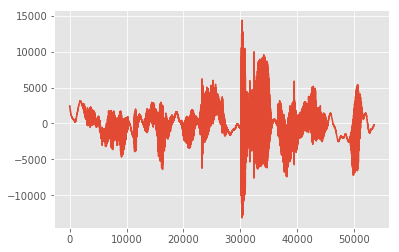

In [30]:
plt.plot(all_candidates.waveform.tolist()[22][3000:-3000])

2017-09-26 15:10:17,200 bci.core.expstruct DEBUG    Creating directory /mnt/cube/earneodo/bci_zf/ss_data/z042/2017-09-24
2017-09-26 15:10:17,248 swissknife.streamtools.findbout INFO     will search for pattern in all waves of folder /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-24
2017-09-26 15:10:17,264 swissknife.streamtools.findbout INFO     found 28
2017-09-26 15:10:17,277 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-24/06-00-02-01.wav
2017-09-26 15:10:24,510 swissknife.streamtools.findbout INFO     79380000 samples loaded at 44100 Hz
2017-09-26 15:10:24,511 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2017-09-26 15:10:24,601 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2017-09-26 15:10:24,662 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 15:10:24,673 swissknife.streamtools.findbout DEBUG    No chunked specgram
2017-09-26 15:10:

2017-09-26 15:17:22,505 swissknife.streamtools.findbout INFO     Returning candidates panda
2017-09-26 15:17:22,507 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-24/06-00-02-05.wav
2017-09-26 15:17:29,507 swissknife.streamtools.findbout INFO     79380000 samples loaded at 44100 Hz
2017-09-26 15:17:29,509 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2017-09-26 15:17:29,559 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2017-09-26 15:17:29,608 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 15:17:29,609 swissknife.streamtools.findbout DEBUG    No chunked specgram
2017-09-26 15:17:29,610 swissknife.streamtools.findbout INFO     Getting pattern spectrogram
2017-09-26 15:17:29,620 swissknife.streamtools.findbout INFO     Getting stream spectrogram
2017-09-26 15:17:52,151 swissknife.streamtools.findbout INFO     Getting all scores in 360623 poin

2017-09-26 15:24:23,358 swissknife.streamtools.findbout DEBUG    Returning clustered candidates
2017-09-26 15:24:23,360 swissknife.streamtools.findbout INFO     Returning candidates panda
2017-09-26 15:24:23,362 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-24/06-00-02-09.wav
2017-09-26 15:24:30,425 swissknife.streamtools.findbout INFO     79380000 samples loaded at 44100 Hz
2017-09-26 15:24:30,425 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2017-09-26 15:24:30,479 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2017-09-26 15:24:30,533 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 15:24:30,534 swissknife.streamtools.findbout DEBUG    No chunked specgram
2017-09-26 15:24:30,535 swissknife.streamtools.findbout INFO     Getting pattern spectrogram
2017-09-26 15:24:30,544 swissknife.streamtools.findbout INFO     Getting stream spectrogram
20

2017-09-26 15:31:20,765 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 15:31:20,773 swissknife.streamtools.findbout DEBUG    Returning clustered candidates
2017-09-26 15:31:20,775 swissknife.streamtools.findbout INFO     Returning candidates panda
2017-09-26 15:31:20,777 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-24/06-00-02-13.wav
2017-09-26 15:31:27,963 swissknife.streamtools.findbout INFO     79380000 samples loaded at 44100 Hz
2017-09-26 15:31:27,964 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2017-09-26 15:31:28,015 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2017-09-26 15:31:28,064 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 15:31:28,065 swissknife.streamtools.findbout DEBUG    No chunked specgram
2017-09-26 15:31:28,066 swissknife.streamtools.findbout IN

2017-09-26 15:38:23,548 swissknife.streamtools.findbout INFO     Found 49 correlation peaks
2017-09-26 15:38:23,549 swissknife.streamtools.findbout DEBUG    actual dt 0.0009977324261853937
2017-09-26 15:38:23,550 swissknife.streamtools.findbout INFO     Found 49 candidates
2017-09-26 15:38:23,550 swissknife.streamtools.findbout INFO     Clustering candidates
2017-09-26 15:38:23,551 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 15:38:23,563 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 15:38:23,570 swissknife.streamtools.findbout DEBUG    Returning clustered candidates
2017-09-26 15:38:23,573 swissknife.streamtools.findbout INFO     Returning candidates panda
2017-09-26 15:38:23,575 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-24/06-00-02-17.wav
2017-09-26 15:38:30,653 swissknife.s

2017-09-26 15:44:09,692 swissknife.streamtools.findbout INFO     done collecting scores
2017-09-26 15:45:23,772 swissknife.streamtools.findbout INFO     Getting spectrogram correlation peaks
2017-09-26 15:45:23,774 swissknife.streamtools.findbout INFO     Finding peaks ...
2017-09-26 15:45:23,776 swissknife.streamtools.findbout INFO     56 peaks found
2017-09-26 15:45:23,779 swissknife.streamtools.findbout INFO     54 peaks left after filtering redundant
2017-09-26 15:45:23,779 swissknife.streamtools.findbout INFO     Found 54 correlation peaks
2017-09-26 15:45:23,780 swissknife.streamtools.findbout DEBUG    actual dt 0.0009977324261853937
2017-09-26 15:45:23,781 swissknife.streamtools.findbout INFO     Found 54 candidates
2017-09-26 15:45:23,782 swissknife.streamtools.findbout INFO     Clustering candidates
2017-09-26 15:45:23,782 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 15:45:23,790 swissknife.streamtools.find

2017-09-26 15:50:48,634 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 15:50:48,635 swissknife.streamtools.findbout DEBUG    No chunked specgram
2017-09-26 15:50:48,636 swissknife.streamtools.findbout INFO     Getting pattern spectrogram
2017-09-26 15:50:48,646 swissknife.streamtools.findbout INFO     Getting stream spectrogram
2017-09-26 15:51:11,347 swissknife.streamtools.findbout INFO     Getting all scores in 360623 points
2017-09-26 15:51:11,351 swissknife.streamtools.findbout INFO     done collecting scores
2017-09-26 15:52:29,820 swissknife.streamtools.findbout INFO     Getting spectrogram correlation peaks
2017-09-26 15:52:29,822 swissknife.streamtools.findbout INFO     Finding peaks ...
2017-09-26 15:52:29,825 swissknife.streamtools.findbout INFO     29 peaks found
2017-09-26 15:52:29,827 swissknife.streamtools.findbout INFO     28 peaks left after filtering redundant
2017-09-26 15:52:29,827 swissknife.streamtools.findbout INFO     Found 28 cor

2017-09-26 15:57:45,307 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-24/06-00-02-28.wav
2017-09-26 15:57:52,323 swissknife.streamtools.findbout INFO     79380000 samples loaded at 44100 Hz
2017-09-26 15:57:52,324 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2017-09-26 15:57:52,378 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2017-09-26 15:57:52,432 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 15:57:52,433 swissknife.streamtools.findbout DEBUG    No chunked specgram
2017-09-26 15:57:52,434 swissknife.streamtools.findbout INFO     Getting pattern spectrogram
2017-09-26 15:57:52,443 swissknife.streamtools.findbout INFO     Getting stream spectrogram
2017-09-26 15:58:15,390 swissknife.streamtools.findbout INFO     Getting all scores in 360623 points
2017-09-26 15:58:15,391 swissknife.streamtools.findbout INFO     done collecting scores
2

2017-09-26 16:04:46,863 swissknife.streamtools.findbout INFO     Found 109 correlation peaks
2017-09-26 16:04:46,863 swissknife.streamtools.findbout DEBUG    actual dt 0.0009977324261853937
2017-09-26 16:04:46,864 swissknife.streamtools.findbout INFO     Found 109 candidates
2017-09-26 16:04:46,865 swissknife.streamtools.findbout INFO     Clustering candidates
2017-09-26 16:04:46,865 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 16:04:46,874 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 16:04:46,881 swissknife.streamtools.findbout DEBUG    Returning clustered candidates
2017-09-26 16:04:46,883 swissknife.streamtools.findbout INFO     Returning candidates panda
2017-09-26 16:04:46,885 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-25/06-00-01-04.wav
2017-09-26 16:04:54,286 swissknife

2017-09-26 16:10:33,556 swissknife.streamtools.findbout INFO     done collecting scores
2017-09-26 16:11:48,169 swissknife.streamtools.findbout INFO     Getting spectrogram correlation peaks
2017-09-26 16:11:48,171 swissknife.streamtools.findbout INFO     Finding peaks ...
2017-09-26 16:11:48,174 swissknife.streamtools.findbout INFO     98 peaks found
2017-09-26 16:11:48,177 swissknife.streamtools.findbout INFO     98 peaks left after filtering redundant
2017-09-26 16:11:48,178 swissknife.streamtools.findbout INFO     Found 98 correlation peaks
2017-09-26 16:11:48,179 swissknife.streamtools.findbout DEBUG    actual dt 0.0009977324261853937
2017-09-26 16:11:48,180 swissknife.streamtools.findbout INFO     Found 98 candidates
2017-09-26 16:11:48,180 swissknife.streamtools.findbout INFO     Clustering candidates
2017-09-26 16:11:48,181 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 16:11:48,189 swissknife.streamtools.find

2017-09-26 16:17:18,347 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 16:17:18,348 swissknife.streamtools.findbout DEBUG    No chunked specgram
2017-09-26 16:17:18,348 swissknife.streamtools.findbout INFO     Getting pattern spectrogram
2017-09-26 16:17:18,358 swissknife.streamtools.findbout INFO     Getting stream spectrogram
2017-09-26 16:17:40,868 swissknife.streamtools.findbout INFO     Getting all scores in 360623 points
2017-09-26 16:17:40,870 swissknife.streamtools.findbout INFO     done collecting scores
2017-09-26 16:18:55,261 swissknife.streamtools.findbout INFO     Getting spectrogram correlation peaks
2017-09-26 16:18:55,263 swissknife.streamtools.findbout INFO     Finding peaks ...
2017-09-26 16:18:55,266 swissknife.streamtools.findbout INFO     66 peaks found
2017-09-26 16:18:55,272 swissknife.streamtools.findbout INFO     65 peaks left after filtering redundant
2017-09-26 16:18:55,273 swissknife.streamtools.findbout INFO     Found 65 cor

2017-09-26 16:24:20,011 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-25/06-00-01-15.wav
2017-09-26 16:24:28,002 swissknife.streamtools.findbout INFO     79380000 samples loaded at 44100 Hz
2017-09-26 16:24:28,003 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2017-09-26 16:24:28,057 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2017-09-26 16:24:28,110 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 16:24:28,111 swissknife.streamtools.findbout DEBUG    No chunked specgram
2017-09-26 16:24:28,112 swissknife.streamtools.findbout INFO     Getting pattern spectrogram
2017-09-26 16:24:28,124 swissknife.streamtools.findbout INFO     Getting stream spectrogram
2017-09-26 16:24:53,715 swissknife.streamtools.findbout INFO     Getting all scores in 360623 points
2017-09-26 16:24:53,715 swissknife.streamtools.findbout INFO     done collecting scores
2

2017-09-26 16:31:27,597 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 16:31:27,608 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 16:31:27,617 swissknife.streamtools.findbout DEBUG    Returning clustered candidates
2017-09-26 16:31:27,620 swissknife.streamtools.findbout INFO     Returning candidates panda
2017-09-26 16:31:27,622 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z042/2017-09-25/06-00-01-19.wav
2017-09-26 16:31:34,786 swissknife.streamtools.findbout INFO     79380000 samples loaded at 44100 Hz
2017-09-26 16:31:34,787 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2017-09-26 16:31:34,841 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2017-09-26 16:31:34,891 swissknife.streamtools.findbout INFO     Getting the spectral scores
2017-09-26 16:

2017-09-26 16:38:34,992 swissknife.streamtools.findbout INFO     23 peaks left after filtering redundant
2017-09-26 16:38:34,993 swissknife.streamtools.findbout INFO     Found 23 correlation peaks
2017-09-26 16:38:34,993 swissknife.streamtools.findbout DEBUG    actual dt 0.0009977324261853937
2017-09-26 16:38:34,994 swissknife.streamtools.findbout INFO     Found 23 candidates
2017-09-26 16:38:34,995 swissknife.streamtools.findbout INFO     Clustering candidates
2017-09-26 16:38:34,995 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 16:38:35,004 swissknife.streamtools.findbout INFO     Attempting to cluster bout candidates by spectrogram similarity
2017-09-26 16:38:35,011 swissknife.streamtools.findbout DEBUG    Returning clustered candidates
2017-09-26 16:38:35,013 swissknife.streamtools.findbout INFO     Returning candidates panda
2017-09-26 16:38:35,015 swissknife.streamtools.findbout INFO     searching for pattern i

2017-09-26 16:44:25,218 swissknife.streamtools.findbout INFO     Getting all scores in 360623 points
2017-09-26 16:44:25,219 swissknife.streamtools.findbout INFO     done collecting scores
2017-09-26 16:45:42,636 swissknife.streamtools.findbout INFO     Getting spectrogram correlation peaks
2017-09-26 16:45:42,639 swissknife.streamtools.findbout INFO     Finding peaks ...
2017-09-26 16:45:42,641 swissknife.streamtools.findbout INFO     2 peaks found
2017-09-26 16:45:42,642 swissknife.streamtools.findbout INFO     2 peaks left after filtering redundant
2017-09-26 16:45:42,643 swissknife.streamtools.findbout INFO     Found 2 correlation peaks
2017-09-26 16:45:42,644 swissknife.streamtools.findbout DEBUG    actual dt 0.0009977324261853937
2017-09-26 16:45:42,645 swissknife.streamtools.findbout INFO     Found 2 candidates
2017-09-26 16:45:42,646 swissknife.streamtools.findbout DEBUG    Returning clustered candidates
2017-09-26 16:45:42,648 swissknife.streamtools.findbout INFO     Returning

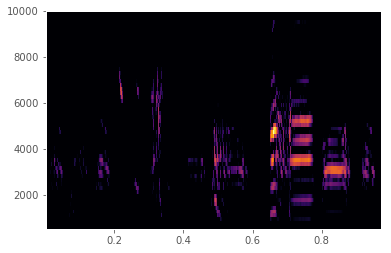

In [18]:
all_sess_cand = []
for d in all_days[-2:]:
    sess_cand = search_bouts_song(bird_id, d, 'motiff_0')
    all_sess_cand.append(sess_cand)

## run a thread with search in many sessions
- The sessions are in all_days

#### Create a log, if you may

In [ ]:
# create file handler which logs even debug messages
log_f_name = os.path.join(raw_data_folder_bird, 'search_bout_many_days.log')
fh = logging.FileHandler(log_f_name)
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
print(log_f_name)

In [12]:
[all_days[-1]]

['2017-10-18']

In [13]:
def find_bout_list(bird_id, sess_list, pattern_name):
    sess_cand_list = [search_bouts_song(bird_id, s, pattern_name) for s in sess_list]
    return pd.concatenate(sess_cand_list)

the_long_search = threadedFunction(args=(find_bout_list, bird_id, [all_days[-1]], 'motiff_1'))
the_long_search.start()


2017-10-18 22:48:36,402 threadtools.threadedfunction INFO     Starting function  in thread threadedFunction-1
2017-10-18 22:48:36,457 bci.core.expstruct DEBUG    Creating directory /mnt/cube/earneodo/bci_zf/ss_data/z028/2017-10-18
2017-10-18 22:48:36,461 swissknife.streamtools.findbout INFO     will search for pattern in all waves of folder /mnt/cube/earneodo/bci_zf/raw_data/z028/2017-10-18
2017-10-18 22:48:36,463 swissknife.streamtools.findbout INFO     found 28
2017-10-18 22:48:36,465 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z028/2017-10-18/06-00-01-01.wav
2017-10-18 22:48:50,477 swissknife.streamtools.findbout INFO     79380000 samples loaded at 44100 Hz
2017-10-18 22:48:50,480 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2017-10-18 22:48:50,634 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2017-10-18 22:48:50,786 swissknife.streamtools.findbout INFO     Getting the spectral

## Debugging and all that jizz

2017-08-10 10:10:51,788 findbout     INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z036/2017-06-21/06-00-01-22.wav


['motiff_0', 'motiff_1', 'con_tag', 'bos_rev_tag', 'bos_tag']


2017-08-10 10:10:56,318 findbout     INFO     79380000 samples loaded at 44100 Hz
2017-08-10 10:10:56,319 findbout     INFO     Calling find_the_bouts
2017-08-10 10:10:56,444 findbout     INFO     Begin to get scores (rms, env_corr)
2017-08-10 10:10:56,565 findbout     INFO     Getting the spectral scores
2017-08-10 10:10:56,566 findbout     DEBUG    No chunked specgram
2017-08-10 10:10:56,567 findbout     INFO     Getting pattern spectrogram
2017-08-10 10:10:56,615 findbout     INFO     Getting stream spectrogram
2017-08-10 10:11:17,100 findbout     INFO     Getting all scores in 360685 points
2017-08-10 10:12:32,666 findbout     INFO     done collecting scores
2017-08-10 10:12:32,924 findbout     INFO     Getting spectrogram correlation peaks
2017-08-10 10:12:32,925 findbout     INFO     Finding peaks ...
2017-08-10 10:12:32,927 findbout     INFO     25 peaks found
2017-08-10 10:12:32,928 findbout     INFO     20 peaks left after filtering redundant
2017-08-10 10:12:32,929 findbout  

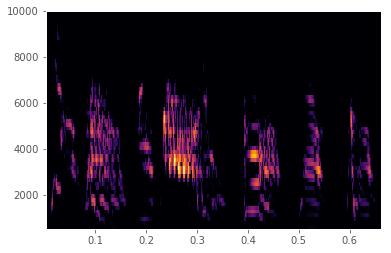

In [51]:
import swissknife.streamtools.findbout as fb
reload(et)
reload(fb)
reload(sp)

stim_ver = '001'

fn = et.file_names(bird_id, stim_ver)

stim_par = et.read_yml(os.path.join(fn['folders']['stim'], 'stim.par.yml'))

search_par = stim_par['search_motiff']
stim_names = list(search_par['motiff_patterns'].keys())
print(stim_names)
stim_name = 'motiff_0'

search_par['corr_thresh'] = 0.5
search_par['db_cut'] = 60
pattern_path = os.path.join(fn['folders']['stim'], search_par['motiff_patterns'][stim_name])
#stream_path = all_raw_file_list[-10]
#stream_path = '/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-08-06/06-00-01-23.wav'
stream_path = one_file
#stream_path = os.path.join('/mnt/cube/earneodo/bci_zf/ss_data/z036/2017-07-10', '06-00-02-11_auto.wav')
candy = fb.search_bouts(stream_path, pattern_path, search_par, chunked_specgram=False, debug=True)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd83aed710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fbd861173d0>], dtype=object)

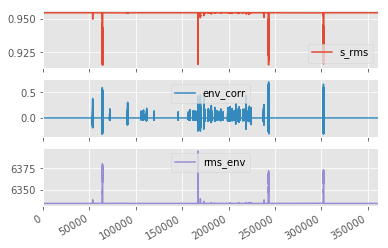

In [52]:
candy[1].plot(subplots=True)

2017-08-09 16:50:17,179 findbout     INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z036/2017-07-10/06-00-02-11.wav
2017-08-09 16:50:21,793 findbout     INFO     79380000 samples loaded at 44100 Hz
2017-08-09 16:50:21,795 findbout     INFO     Calling find_the_bouts
2017-08-09 16:50:21,831 findbout     INFO     Begin to get scores (rms, env_corr)
2017-08-09 16:50:21,868 findbout     INFO     Getting the spectral scores
2017-08-09 16:50:21,869 findbout     DEBUG    No chunked specgram
2017-08-09 16:50:21,870 findbout     INFO     Getting pattern spectrogram
2017-08-09 16:50:21,915 findbout     INFO     Getting stream spectrogram
2017-08-09 16:50:43,076 findbout     INFO     Getting all scores in 360685 points
2017-08-09 16:51:51,319 findbout     INFO     done collecting scores
2017-08-09 16:51:51,569 findbout     INFO     Getting spectrogram correlation peaks
2017-08-09 16:51:51,570 findbout     INFO     Finding peaks ...
2017-08-09 16:51:51,573 findbout     INFO  

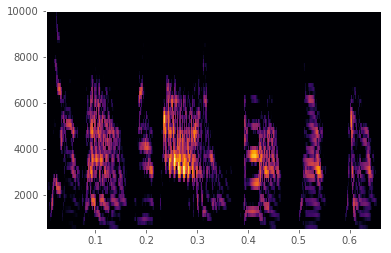

In [70]:
allcand = map(lambda x: fb.search_bouts(x, pattern_path, search_par, chunked_specgram=False), all_raw_file_list[0:2])

In [77]:
pd_cand.to_pickle?

In [74]:
pd_cand = pd.concat(allcand)

In [62]:
stream_path = '/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-08-06/06-00-01-23.wav'

'/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-07-20/06-00-01-21.wav'

In [68]:
candy['file'] = stream_path

In [69]:
candy

,env_corr,spectral_diff,start,bout,bout_2d,file
0,0.873837,0.991602,7827599,True,False,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
1,0.821344,0.990621,7889199,True,True,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
2,0.785084,1.000390,7858179,True,False,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
3,0.827577,0.966446,10757119,True,True,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
4,0.843362,0.976440,7577459,True,False,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
5,0.857247,0.982842,10660759,True,True,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
6,0.887709,0.951543,10695519,True,False,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
7,0.901496,0.968401,7485499,True,True,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
8,0.775116,1.035839,313939,False,False,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...
9,0.763938,1.048291,344299,False,True,/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-0...


In [66]:
pat =WavData(stream_path)
alpat = Chunk(pat).data.flatten()

2017-08-09 16:30:26,508 streamtools.streams INFO     wavdata


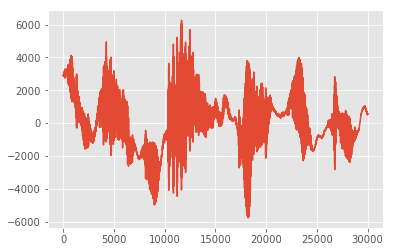

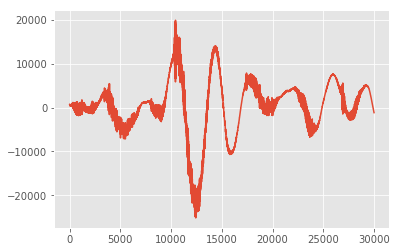

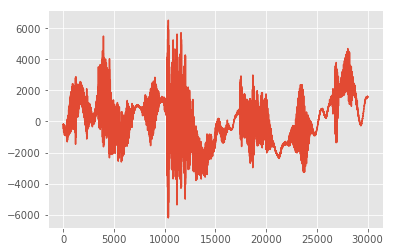

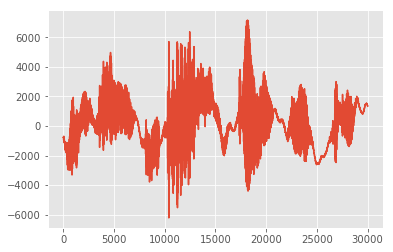

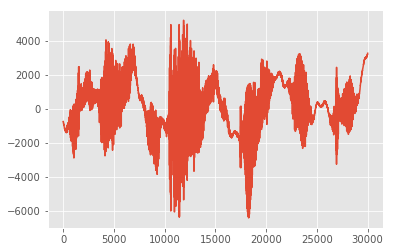

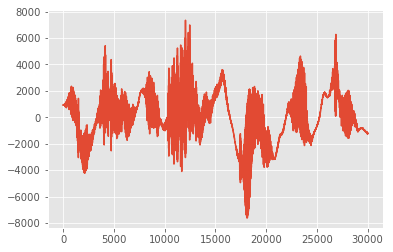

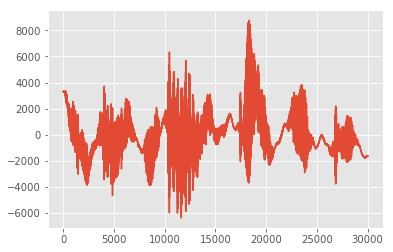

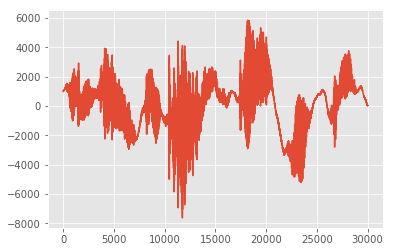

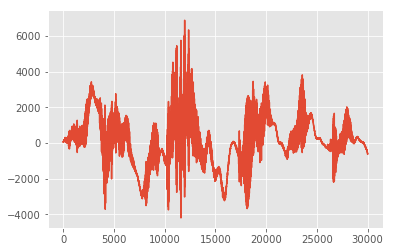

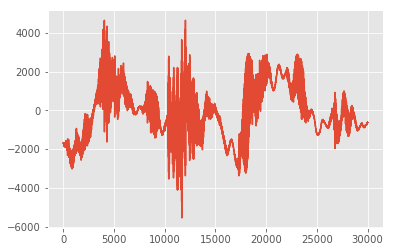

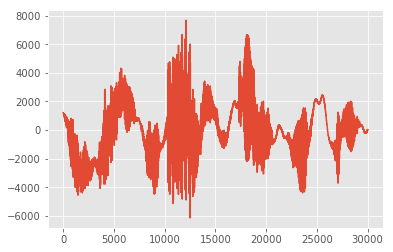

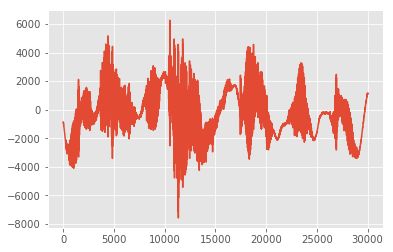

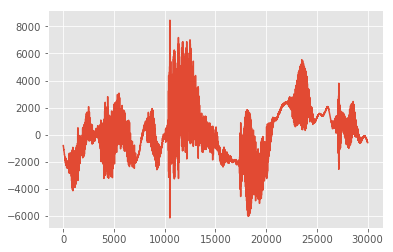

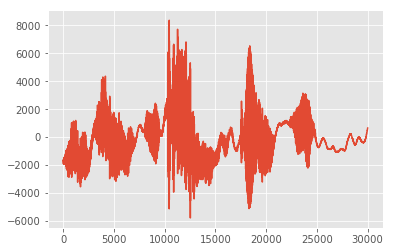

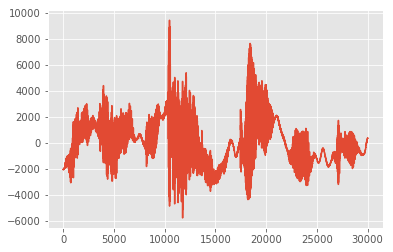

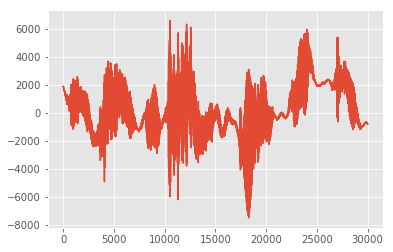

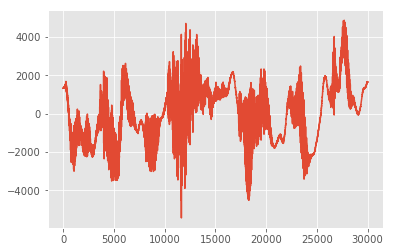

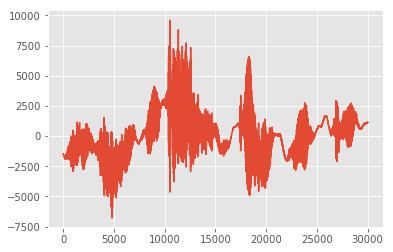

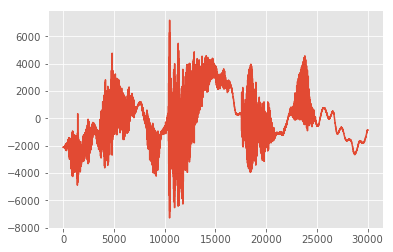

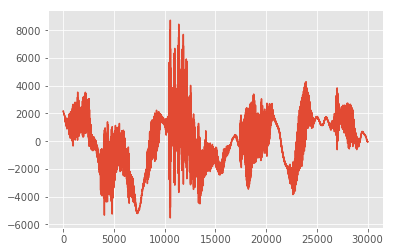

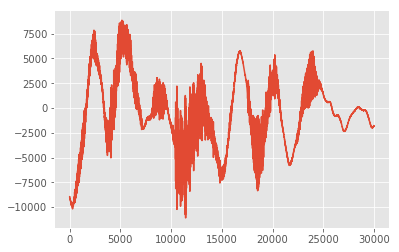

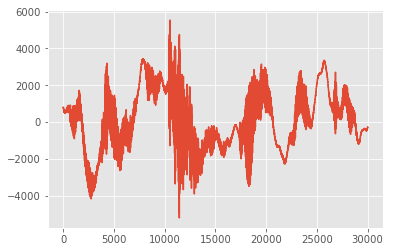

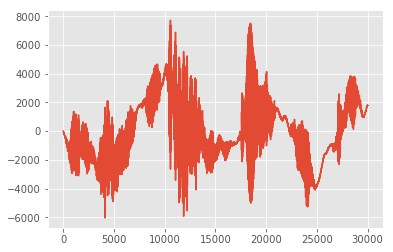

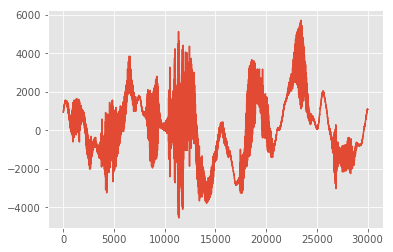

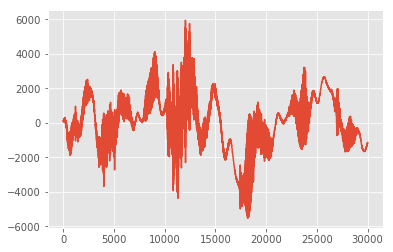

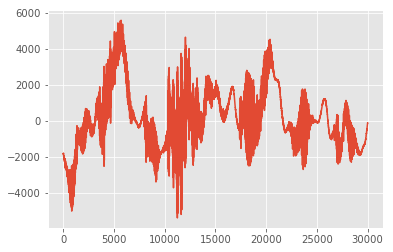

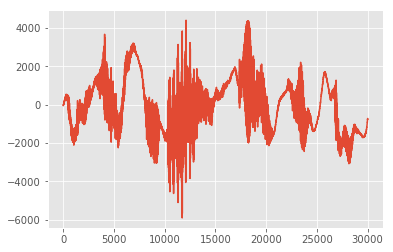

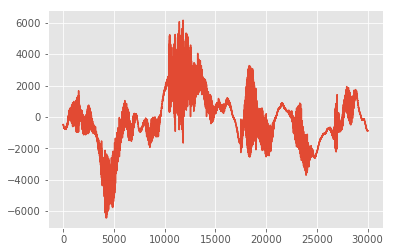

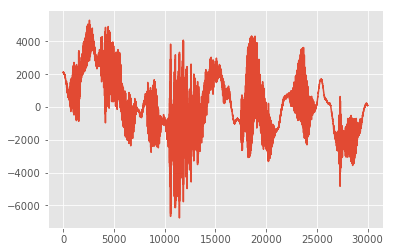

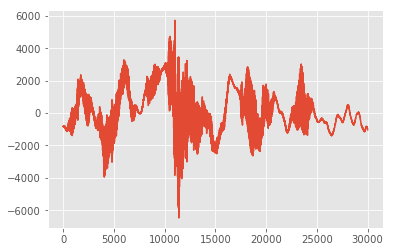

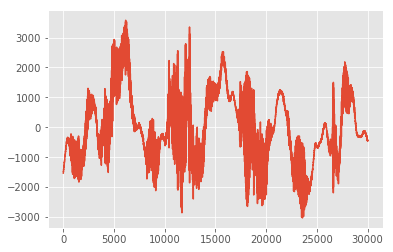

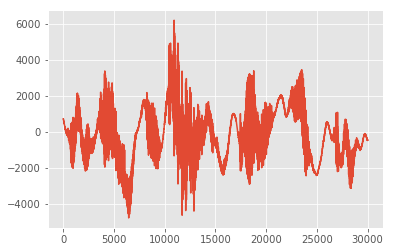

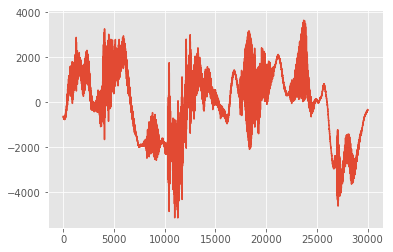

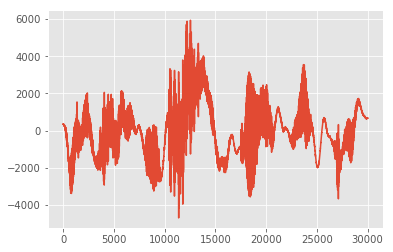

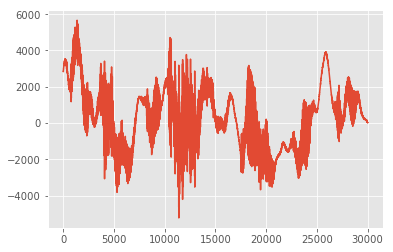

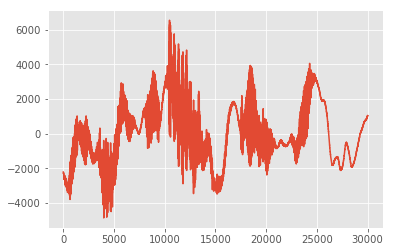

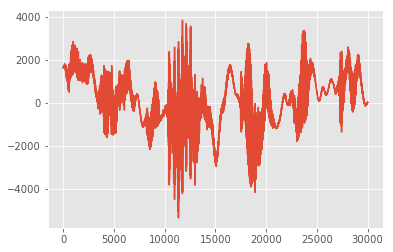

In [67]:
for start in candy.start.tolist():
    plt.figure()
    plt.plot(alpat[start:start+30000])

In [34]:
alpat.samples

33925

In [21]:
list(search_par['motiff_patterns'].keys())

['motiff_0', 'motiff_1', 'con_tag', 'bos_rev_tag', 'bos_tag']

In [13]:
fn

{'folders': {'kai': '/mnt/cube/kai/results/z036/001',
  'prb': '/mnt/cube/earneodo/bci_zf/probes',
  'proc': '/mnt/cube/earneodo/bci_zf/proc_data/z036/001',
  'raw': '/usr/local/experiment/raw_data/z036/001',
  'rw': '/mnt/cube/earneodo/bci_zf/raw_data/z036/001',
  'ss': '/mnt/cube/earneodo/bci_zf/ss_data/z036/001',
  'stim': '/mnt/cube/earneodo/bci_zf/stim_data/z036/001',
  'templ': '/mnt/cube/earneodo/bci_zf/templates',
  'tmp': '/usr/local/experiment/tmp_data/z036/001'},
 'locations': {'archive': '/mnt/cube/earneodo/archive/bci_zf',
  'experiment': '/mnt/cube/earneodo/bci_zf',
  'experiment_local': '/usr/local/experiment',
  'repos': '/mnt/cube/earneodo/repos',
  'scratch': '/usr/local/experiment/scratchpad',
  'store': '/Data/bci_zf'},
 'structure': {'cand': 'experiment.mot.h5',
  'evt': 'experiment.kwe',
  'kk_par': 'params.prm',
  'kk_prb': '*.prb',
  'ks_cfg': 'config.m',
  'ks_map': 'chanMap.mat',
  'ks_mas': 'master.m',
  'ks_par': 'params.py',
  'mic': 'experiment-rec_000.mic